# Step 1 - Scraping the pokedex

## Step 1.1 Use BeautifulSoup to extract all the table rows as a list. 

In [123]:
#Use BeautifulSoup to extract all the table rows as a list. 
#Create an HTTP request for the page 
import requests
from bs4 import BeautifulSoup
url='https://pokemondb.net/pokedex/all'
import re

In [124]:
page = requests.get(url)
# Response code is returned
page

<Response [200]>

In [125]:
page_soup = BeautifulSoup(page.text, 'html.parser')
#page_soup.prettify()


In [126]:
import sys
sys.getsizeof(page)

56

In [127]:
header_raw=page_soup.find_all(name="div", class_="sortwrap")
header=[]
for i in header_raw:
    header.append(i.text)

In [128]:
header

['#',
 'Name',
 'Type',
 'Total',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed']

In [129]:
body = page_soup.find_all('tbody')
print("Number of results: " + str(len(body)))
#page_list[0].find_all("tr")
content=[]
for each in page_soup.findAll(name = 'td'):
    content.append(each.contents)
rows=[content[i:i+10] for i in range(0, len(content), 10)]   


Number of results: 1


In [130]:
rows.append(header)
rowsfinal=[]
for row in rows:
    row=list(row)
    rowsfinal.append(row)

In [131]:
len(rowsfinal)

927

There are 927 rows in the extracted list, including the header

## Step 1.2 Extract name,url, types,total points and statistics of the first pokemon as a test

In [132]:
bulbasaur=rowsfinal[0]
string=''.join(str(e) for e in bulbasaur)
string

'[<span class="infocard-cell-img"><span class="img-fixed icon-pkmn" data-alt="Bulbasaur icon" data-src="https://img.pokemondb.net/sprites/sun-moon/icon/bulbasaur.png"></span></span>, <span class="infocard-cell-data">001</span>][<a class="ent-name" href="/pokedex/bulbasaur" title="View pokedex for #001 Bulbasaur">Bulbasaur</a>][<a class="type-icon type-grass" href="/type/grass">Grass</a>, <br/>, \' \', <a class="type-icon type-poison" href="/type/poison">Poison</a>][\'318\'][\'45\'][\'49\'][\'49\'][\'65\'][\'65\'][\'45\']'

In [133]:
#The name of the pokemon
regexName = r'/pokedex/(.*)"\stitle'
Name = re.findall(regexName, string)
print(Name)

['bulbasaur']


In [134]:
#The url of the pokemon
regexLink = r'href="(.*)"\stitle'
Link = re.findall(regexLink, string)
print(Link)

['/pokedex/bulbasaur']


In [135]:
#The types of the pokemon
regexType1 = r'(?<=/type/).*>(\w+)(?=</a>\,)'
regexType2 =  r'(?<=/type/).*>(\w+)(?=</a>\])'
Type1 = re.findall(regexType1, string)
Type2 = re.findall(regexType2, string)
Type_List=Type1+Type2
Type=[' '.join(str(t) for t in Type_List)]
print(Type)

['Grass Poison']


In [136]:
#The total points of the pokemon
regexTotal = r'(?<=\[\')(\d{3})'
Total = re.findall(regexTotal, string)
print(Total)

['318']


In [137]:
#The list of ID Number, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed of the pokemon
regexID = r'(\d+)</span>'
ID = re.findall(regexID, string)

regexNumeric = r'(?<=[\d+]\'\]\[\')(\d+)'
Numeric = re.findall(regexNumeric, string)

statistics=ID+Numeric
print(statistics)

['001', '45', '49', '49', '65', '65', '45']


## Step 1.3 Define a function that takes in a row of the pokedex table and returns it as a DataFrame with a single row. 

In [138]:

#Create a single DataFrame by appending these rows. 
def pokedex(rowsfinal):
    import pandas as pd
    statistics=[]
    Name=[]
    Link=[]
    Type=[]
    Total=[]
    regexName = r'/pokedex/(.*)"\stitle'
    regexLink = r'href="(.*)"\stitle'
    regexType1 = r'(?<=/type/).*>(\w+)(?=</a>\,)'
    regexType2 =  r'(?<=/type/).*>(\w+)(?=</a>\])'
    regexTotal = r'(?<=\[\')(\d{3}?)'
    regexID = r'(\d+)</span>'
    regexNumeric = r'(?<=[\d+]\'\]\[\')(\d+)'
    for i in range(len(rowsfinal)-1):
        string=''.join(str(e) for e in rowsfinal[i])
        Name.append(re.findall(regexName, string))
        ID = re.findall(regexID, string)
        Numeric = re.findall(regexNumeric, string)
        statistics.append(ID+Numeric)
        Link.append(re.findall(regexLink, string))
        Type1 = re.findall(regexType1, string)
        Type2 = re.findall(regexType2, string)
        Type_List=Type1+Type2
        Type.append([' '.join(str(t) for t in Type_List)])
        Total.append(re.findall(regexTotal, string)[0])
    df=pd.DataFrame((list(zip(statistics,Name,Link,Type,Total))))
    return df
        

In [139]:
df=pokedex(rowsfinal)
df.head()

,0,1,2,3,4
0,"[001, 45, 49, 49, 65, 65, 45]",[bulbasaur],[/pokedex/bulbasaur],[Grass Poison],318
1,"[002, 60, 62, 63, 80, 80, 60]",[ivysaur],[/pokedex/ivysaur],[Grass Poison],405
2,"[003, 80, 82, 83, 100, 100, 80]",[venusaur],[/pokedex/venusaur],[Grass Poison],525
3,"[003, 80, 100, 123, 122, 120, 80]",[venusaur],[/pokedex/venusaur],[Grass Poison],625
4,"[004, 39, 52, 43, 60, 50, 65]",[charmander],[/pokedex/charmander],[Fire],309


# Step 2 - Cleaning the Pokedex

## Step 2.1 Add column names to the DataFrame. Convert strings to numeric where appropriate. Make the ID number the first column in the DataFrame

In [140]:

df.columns = ['statistics','Name','URL','Type','Total']


In [141]:
df['statistics']=df['statistics'].apply(', '.join)


In [142]:

df['Name'] = df['Name'].str.get(0)
df['URL'] = df['URL'].str.get(0)
df['Type'] = df['Type'].str.get(0)

In [143]:
df.head()

,statistics,Name,URL,Type,Total
0,"001, 45, 49, 49, 65, 65, 45",bulbasaur,/pokedex/bulbasaur,Grass Poison,318
1,"002, 60, 62, 63, 80, 80, 60",ivysaur,/pokedex/ivysaur,Grass Poison,405
2,"003, 80, 82, 83, 100, 100, 80",venusaur,/pokedex/venusaur,Grass Poison,525
3,"003, 80, 100, 123, 122, 120, 80",venusaur,/pokedex/venusaur,Grass Poison,625
4,"004, 39, 52, 43, 60, 50, 65",charmander,/pokedex/charmander,Fire,309


In [144]:
new = df['statistics'].str.split(",", n = 6, expand = True) 


In [145]:
df['ID Number']=new[0]
df['HP']=new[1]
df['Attack']=new[2]
df['Defense']=new[3]
df['Sp.Atk']=new[4]
df['Sp.Def']=new[5]
df['Speed']=new[6]

In [146]:
df=df.drop('statistics', axis=1) 

In [147]:
df['Total']=df['Total'].astype(float)
df['HP']=df['HP'].astype(float)
df['Attack']=df['Attack'].astype(float)
df['Defense']=df['Defense'].astype(float)
df['Sp.Atk']=df['Sp.Atk'].astype(float)
df['Sp.Def']=df['Sp.Def'].astype(float)
df['Speed']=df['Speed'].astype(float)

In [148]:
df=df.set_index('ID Number')


In [149]:
df.head()

,Name,URL,Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed
ID Number,,,,,,,,,,
001,bulbasaur,/pokedex/bulbasaur,Grass Poison,318.0,45.0,49.0,49.0,65.0,65.0,45.0
002,ivysaur,/pokedex/ivysaur,Grass Poison,405.0,60.0,62.0,63.0,80.0,80.0,60.0
003,venusaur,/pokedex/venusaur,Grass Poison,525.0,80.0,82.0,83.0,100.0,100.0,80.0
003,venusaur,/pokedex/venusaur,Grass Poison,625.0,80.0,100.0,123.0,122.0,120.0,80.0
004,charmander,/pokedex/charmander,Fire,309.0,39.0,52.0,43.0,60.0,50.0,65.0


## Step 2.2 Create 18 dummy variables for each type of pokemon. 

In [150]:

import pandas as pd
dummy=df['Type'].str.get_dummies(sep=' ')

In [151]:

df1=pd.concat([df,dummy],axis=1)
len(df1.columns)

28

## Step 2.3 Remove duplicate values of pokemon based on the URL

In [152]:

df1.drop_duplicates(subset ="URL", 
                     keep = 'first', inplace = True) 
len(df1)

809

## Step 2.4 create a sample of the pokemon.

In [153]:
#Add a dummy variable to the DataFrame called "sample" that tags every 4th pokemon to be included in the sample
df1['sample']=(df1.index.astype('int64') % 4==0).astype('int64')

In [154]:
samples=df1['Name'][df1['sample']==1]

# Step 3 - Scraping Individual Pages

## Step 3.1 Scrape the main image for Bulbasaur in a general way that could be applied to other pokemon pages by searching for the relevant tag and extracting the image URL. 

In [155]:

from IPython.display import Image


In [156]:
urlimage='https://pokemondb.net/pokedex/bulbasaur'
image = requests.get(urlimage)
# Response code is returned
image_soup = BeautifulSoup(image.text, 'html.parser')
#image_soup.prettify()

In [157]:
image_string=''.join(str(e) for e in image_soup.find_all('img'))
print(image_string)


<img alt="Bulbasaur artwork by Ken Sugimori" height="336" src="https://img.pokemondb.net/artwork/bulbasaur.jpg" width="360"/><img alt="Bulbasaur  sprite from Red &amp; Blue" class="img-fixed img-sprite-v1" src="https://img.pokemondb.net/sprites/red-blue/normal/bulbasaur.png"/><img alt="Bulbasaur  sprite from Silver" class="img-fixed img-sprite-v3" src="https://img.pokemondb.net/sprites/silver/normal/bulbasaur.png"/><img alt="Bulbasaur  sprite from Ruby &amp; Sapphire" class="img-fixed img-sprite-v5" src="https://img.pokemondb.net/sprites/ruby-sapphire/normal/bulbasaur.png"/><img alt="Bulbasaur  sprite from Diamond &amp; Pearl" class="img-fixed img-sprite-v8" src="https://img.pokemondb.net/sprites/diamond-pearl/normal/bulbasaur.png"/><img alt="Bulbasaur  sprite from Black &amp; White" class="img-fixed img-sprite-v11" src="https://img.pokemondb.net/sprites/black-white/normal/bulbasaur.png"/><img alt="Bulbasaur  sprite from X &amp; Y" class="img-fixed img-sprite-v13" src="https://img.poke

In [158]:
#Display image
image= re.findall('https://.*/.*/.*.jpg', image_string)
image[0]

'https://img.pokemondb.net/artwork/bulbasaur.jpg'

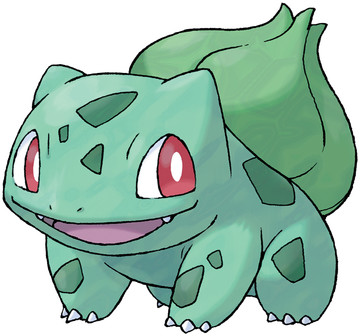

In [159]:
import requests
import IPython.display as Disp
Disp.Image(requests.get(image[0]).content)

## Step 3.2 Extract the location table.

In [160]:

url='https://pokemondb.net/pokedex/bulbasaur'
tables = pd.read_html(requests.get(url, headers={'User-agent': 'Mozilla/5.0'}).text)

In [161]:
#table that contains the locations for Bulbasaur
tables[15]

,0,1
0,RedBlue,Pallet Town
1,Yellow,Cerulean City
2,GoldSilverCrystal,Trade/migrate from another game
3,RubySapphire,Trade/migrate from another game
4,FireRedLeafGreen,Pallet Town
5,Emerald,Trade/migrate from another game
6,DiamondPearlPlatinum,Trade/migrate from another game
7,HeartGoldSoulSilver,Pallet Town
8,BlackWhiteBlack 2White 2,Trade/migrate from another game
9,XY,Lumiose City


## Step 3.3 Transpose the DataFrame such that each column is a video game and each row/cell is the location 

In [162]:
table=tables[15].T
table.columns = table.iloc[0]
table=table.drop(table.index[0])

In [163]:
table

,RedBlue,Yellow,GoldSilverCrystal,RubySapphire,FireRedLeafGreen,Emerald,DiamondPearlPlatinum,HeartGoldSoulSilver,BlackWhiteBlack 2White 2,XY,Omega RubyAlpha Sapphire,SunMoon,Ultra SunUltra Moon,Let's Go PikachuLet's Go Eevee
1,Pallet Town,Cerulean City,Trade/migrate from another game,Trade/migrate from another game,Pallet Town,Trade/migrate from another game,Trade/migrate from another game,Pallet Town,Trade/migrate from another game,Lumiose City,Trade/migrate from another game,Trade/migrate from another game,Route 2,"Cerulean City, Viridian Forest"


## Step 3.4 Extract the location table and transpose it for all the pokemon in the sample 

In [164]:
#Set up the pokeman route names
import time
samples=df1['Name'][df1['sample']==1]
route_names=list(map(lambda x:x.lower(),samples))
del route_names[-1]

In [165]:
#Extract the location table and transpose it for all the pokemon in the sample 
dfs = []
for route_name in route_names:
    url='https://pokemondb.net/pokedex/'+route_name
    tables = pd.read_html(requests.get(url, headers={'User-agent': 'Mozilla/5.0'}).text)
    tables=tables[-2].T
    tables.columns = tables.iloc[0]
    tables=tables.drop(tables.index[0])
    tables['Name']=route_name
    time.sleep(0.5)
    dfs.append(tables)
print("Finished")

Finished


In [166]:
#Get the size of the table list we just created
import sys
sys.getsizeof(dfs)

1672

## Because the location table is not in the same format for every page, so we will be extracting only the information for the X and Y games

In [167]:
#Check if the the column 'XY' is in the DataFrame.create a new DataFrame with only the name for the pokemon and the 'XY' column. 
#Append that DataFrame to a list to concatenate with the other pokemon that have the XY location column. 
dfs1=[]
for df in dfs:
    if 'XY' in df.columns:
        dfs1.append(df[['Name','XY']])


In [168]:
#Create a single DataFrame that contains the name or URL of the pokemon and the XY location.
#Append all the sample pokemon and their XY locations to a single DataFrame.
XY=pd.DataFrame()
XY=XY.append(dfs1,ignore_index=True)
XY.head()

,Name,XY
0,charmander,Lumiose City
1,wartortle,Evolve Squirtle
2,butterfree,Evolve Caterpie/Metapod
3,pidgey,"Route 2, 3"
4,raticate,Trade/migrate from another game


In [169]:
#test length of the new dataframe
len(XY)


141

# Step 4 - Analysis

## Step 4.1 Which type has the highest and lowest average attack? Average defense? 

In [170]:
#Create a table that shows the average  attack and defense for each type. 
sampleDF=df1[df1['sample']==1]

In [171]:
dummies=list(sampleDF.columns[10:28])
dummies

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [174]:
pivot=[]
for dummy in dummies:
    pivot.append(sampleDF.pivot_table(values=['Attack','Defense'],columns=dummy,aggfunc='mean'))

In [217]:
pivot_table=pd.concat(pivot, axis=1)

In [218]:
pivot_table.drop(0, axis=1, inplace=True)

In [219]:
pivot_table.columns=dummies

In [220]:
#Each type should be a row. Average attack and defense should be columns.
pivot_table=pivot_table.T

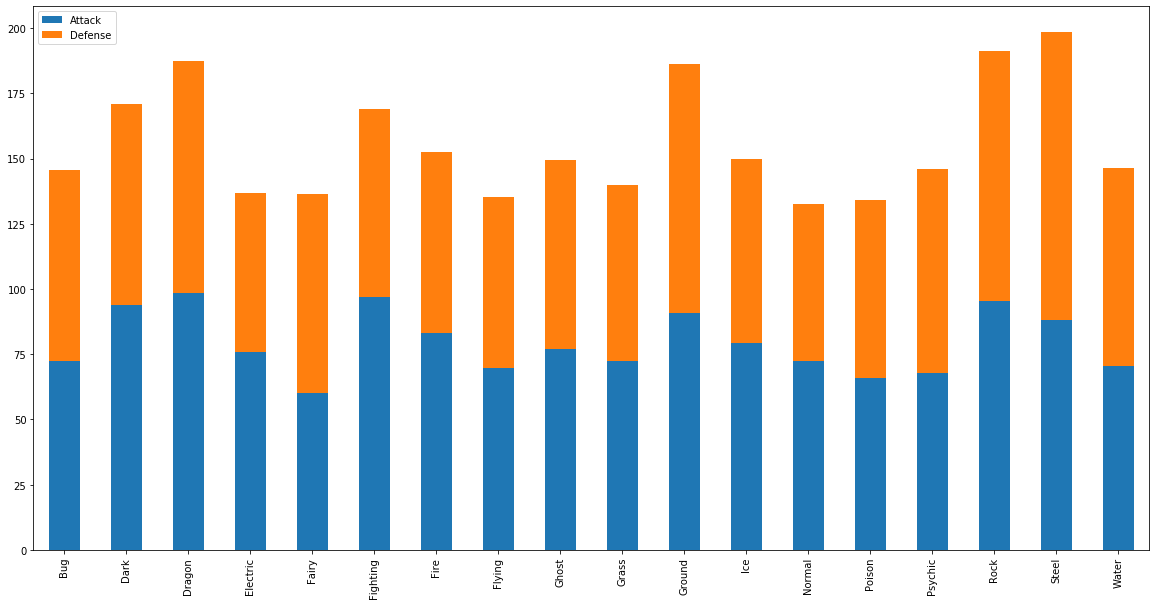

In [241]:
MeanAttackDefense=pivot_table.plot(kind='bar', stacked=True, width=0.5,figsize=(20,10)).get_figure()
MeanAttackDefense.savefig('MeanAttackDefense.pdf')

In [179]:

# get the index position of max values in every column
maxValueType = pivot_table.idxmax()
 
print("Max values of columns are at row index position :")
print(maxValueType)

Max values of columns are at row index position :
Attack     Dragon
Defense     Steel
dtype: object


In [180]:

# get the index position of min values in every column
minValueType = pivot_table.idxmin()
 
print("Min values of columns are at row index position :")
print(minValueType)

Min values of columns are at row index position :
Attack      Fairy
Defense    Normal
dtype: object


The Pokemon type that has the maximum average attack is Dragon, the type that has the maximum avaerage defense is steel

The Pokemon type that has the minimum average attack is Fairy, the type that has the minimum avaerage defense is Normal

## Step 4.2 For the locations in pokemon X/Y, which location has the highest average total point score?

In [181]:
#Join the pokedex data to the  location DataFrame created in Step 3.4. 
merged=pd.merge(XY, df1, on='Name', how='inner')
merged.head()

,Name,XY,URL,Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,...,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,sample
0,charmander,Lumiose City,/pokedex/charmander,Fire,309.0,39.0,52.0,43.0,60.0,50.0,...,0,0,0,0,0,0,0,0,0,1
1,wartortle,Evolve Squirtle,/pokedex/wartortle,Water,405.0,59.0,63.0,80.0,65.0,80.0,...,0,0,0,0,0,0,0,0,1,1
2,butterfree,Evolve Caterpie/Metapod,/pokedex/butterfree,Bug Flying,395.0,60.0,45.0,50.0,90.0,80.0,...,0,0,0,0,0,0,0,0,0,1
3,pidgey,"Route 2, 3",/pokedex/pidgey,Normal Flying,251.0,40.0,45.0,40.0,35.0,35.0,...,0,0,0,1,0,0,0,0,0,1
4,raticate,Trade/migrate from another game,/pokedex/raticate,Normal,413.0,55.0,81.0,60.0,50.0,70.0,...,0,0,0,1,0,0,0,0,0,1


In [232]:
XY_table=merged.set_index('XY').groupby(by='XY').mean()['Total']

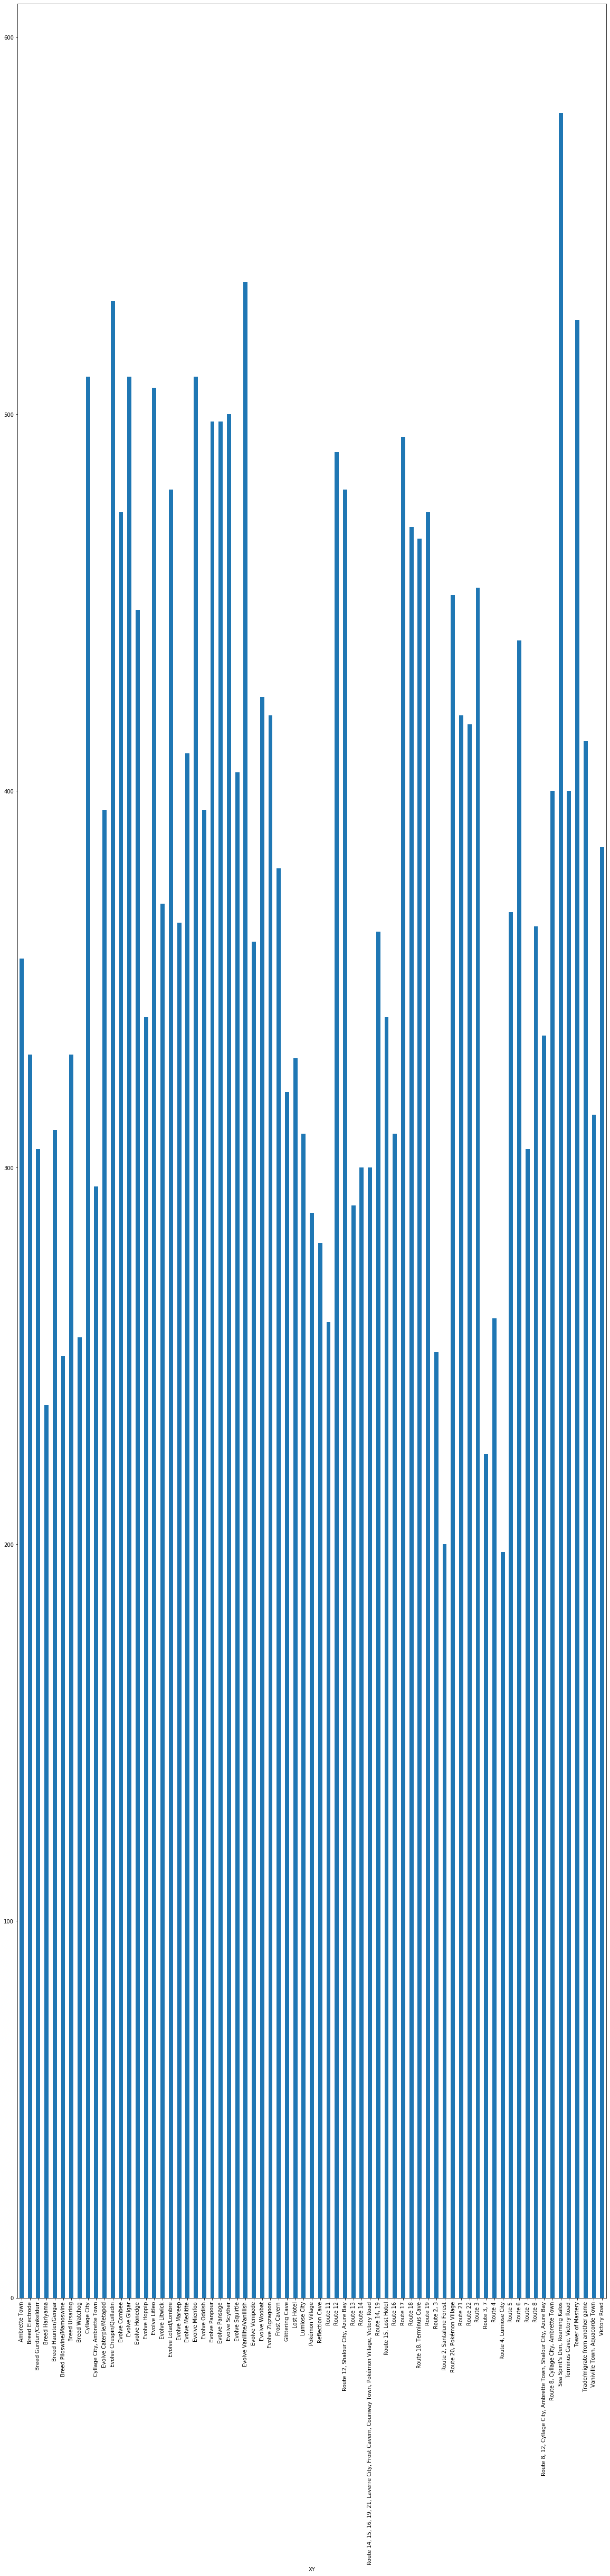

In [237]:
#XY_table.plot.bar(rot=270)
MaxAverageTotal_in_XY=XY_table.plot(kind='bar', stacked=True, width=0.5,figsize=(20,80)).get_figure()
MaxAverageTotal_in_XY.savefig('MaxAverageTotal_in_XY.pdf')

In [183]:
maxValuelocation = XY_table.idxmax()
 
print("Location has the highest average total point score :")
print(maxValuelocation)

Location has the highest average total point score :
Sea Spirit's Den, Roaming Kalos


In [184]:
XY_table[maxValuelocation]

580.0

Location has the highest average total point score is Sea Spirit's Den, Roaming Kalos; the highest average total points is 580